In [21]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

import glob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 150
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def make_best_spec_high_sens_scorer(min_sensitivity: float = 0.98):

    def get_best_spec_high_sens(ytest, yscore):
        thrs = np.unique(yscore)
        best_spec = 0
        for thr in thrs:
            preds = yscore > thr
            tn, fp, fn, tp = metrics.confusion_matrix(ytest, preds).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)

            if sensitivity >= min_sensitivity:
                best_spec = max(specificity, best_spec)
        return best_spec

    return get_best_spec_high_sens


def get_best_args(val_df_group, model_name):
    return val_df_group.filter(regex=model_name, axis=0).round(2).sort_values(
        by=['spec90', 'aps'], kind='mergesort', ascending=False)['args'].iloc[0]

In [23]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET != 'csi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET != 'csi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        else:
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [37]:
DATASET = 'iai'
seeds = sorted([
    int(path.split('_')[-1]) for path in glob.glob(f'results/{DATASET}/seed_*')])

In [38]:
for seed in seeds:
    dct = pkl.load(open(f'results/{DATASET}/seed_{seed}/best_models.pkl', 'rb'))
    pmodel_df = pd.read_csv(f'results/{DATASET}/seed_{seed}/pmodel_val.csv').set_index('Unnamed: 0')
    print(seed, dct['pfigs_old'].max_rules, dct['pfigs_young'].max_rules, 
        dct['figs_old'].max_rules, dct['figs_young'].max_rules, dct['figs_all'].max_rules,
        get_best_args(pmodel_df, f'^PFIGS'))

0 12 8 16 8 8 LL
1 16 8 16 8 8 LL
2 12 16 8 8 8 LS
4 12 8 12 8 8 LS
7 16 12 8 8 8 LL
11 16 12 8 8 8 LS
12 8 16 8 8 8 GBS
13 8 16 16 8 8 GBL
15 12 8 8 8 8 LL
16 12 12 12 8 8 LS


In [27]:
dct

{'cart_all': DecisionTreeClassifier(max_leaf_nodes=16, random_state=0),
 'figs_all': FIGSClassifier(max_rules=8),
 'tao_all': TaoTreeClassifier(model_args={'max_leaf_nodes': 8, 'random_state': 0},
                   n_iters=1, update_scoring='average_precision'),
 'cart_old': DecisionTreeClassifier(max_leaf_nodes=12, random_state=0),
 'figs_old': FIGSClassifier(max_rules=8),
 'tao_old': TaoTreeClassifier(model_args={'max_leaf_nodes': 12, 'random_state': 0},
                   n_iters=1, update_scoring='average_precision'),
 'pecarn_old': <__main__.PECARNModel at 0x7f84e2ec73a0>,
 'cart_young': DecisionTreeClassifier(max_leaf_nodes=8, random_state=0),
 'figs_young': FIGSClassifier(max_rules=8),
 'tao_young': TaoTreeClassifier(model_args={'max_leaf_nodes': 8, 'random_state': 0},
                   n_iters=1, update_scoring='average_precision'),
 'pecarn_young': <__main__.PECARNModel at 0x7f84e2ea2d10>,
 'pecarn_combine': <__main__.TransferTree at 0x7f84e2ea16c0>,
 'figs_combine': <__main

In [10]:
SPLIT_SEED = 0
pmodel_df = pd.read_csv(f'results/{DATASET}/seed_{SPLIT_SEED}/pmodel_val.csv').set_index('Unnamed: 0')
PMODEL = get_best_args(pmodel_df, f'^PFIGS')

In [11]:
PMODEL

'LS'

### data setup

In [12]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

data/imodels_data/tbi_pecarn_pred.csv


In [13]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df.drop(columns=['Age<2_no', 'Age<2_yes'])
feature_names = X_df_clean.columns

X_young, X_old = X_df_clean[~is_group_1], X_df_clean[is_group_1]
y_young, y_old = y[~is_group_1], y[is_group_1]

# X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
#     model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
# X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val = (
#     model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, test_size=0.25, random_state=SPLIT_SEED))

# X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
# X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
# y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
# y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

# X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
# y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

## Visualizing final models

In [51]:
# best_models = pkl.load(open(f'results_2/{DATASET}/seed_{SPLIT_SEED}/best_models.pkl', 'rb'))

In [52]:
# def vizfigs(name):
#     best_models[name].feature_names_ = feature_names
#     print(best_models[name])

In [53]:
# plot_tree(best_models['cart_old'], feature_names=feature_names)

In [14]:
X_df_clean.columns.tolist()

['Seiz',
 'ActNorm',
 'Vomit',
 'Intubated',
 'Paralyzed',
 'Sedated',
 'AMS',
 'AMSAgitated',
 'AMSSleep',
 'AMSSlow',
 'AMSRepeat',
 'AMSOth',
 'FontBulg',
 'SFxBas',
 'SFxBasHem',
 'SFxBasOto',
 'SFxBasPer',
 'SFxBasRet',
 'SFxBasRhi',
 'Hema',
 'Clav',
 'ClavFace',
 'ClavNeck',
 'ClavFro',
 'ClavOcc',
 'ClavPar',
 'ClavTem',
 'NeuroD',
 'NeuroDMotor',
 'NeuroDSensory',
 'NeuroDCranial',
 'NeuroDReflex',
 'NeuroDOth',
 'OSI',
 'OSIExtremity',
 'OSICut',
 'OSICspine',
 'OSIFlank',
 'OSIAbdomen',
 'OSIPelvis',
 'OSIOth',
 'Drugs',
 'AgeInMonth',
 'AgeTwoPlus',
 'InjuryMech_Assault',
 'InjuryMech_BikeCol',
 'InjuryMech_BikeMV',
 'InjuryMech_FallElev',
 'InjuryMech_FallStair',
 'InjuryMech_FallToGround',
 'InjuryMech_MVC',
 'InjuryMech_ObjStruckHead',
 'InjuryMech_Other',
 'InjuryMech_OtherWheelCrash',
 'InjuryMech_PedesMV',
 'InjuryMech_RanIntoStatObj',
 'InjuryMech_Sports',
 'High_impact_InjSev_High',
 'High_impact_InjSev_Low',
 'High_impact_InjSev_Moderate',
 'Amnesia_verb_0.0',
 'Am

## tbi

In [15]:
final_old = pkl.load(open(f'results/{DATASET}/all_model_old.pkl', 'rb'))
final_young = pkl.load(open(f'results/{DATASET}/all_model_young.pkl', 'rb'))
final_old.feature_names_ = feature_names
final_young.feature_names_ = feature_names

In [16]:
X_df_clean.columns

Index(['Seiz', 'ActNorm', 'Vomit', 'Intubated', 'Paralyzed', 'Sedated', 'AMS',
       'AMSAgitated', 'AMSSleep', 'AMSSlow',
       ...
       'HemaLoc_Frontal', 'HemaLoc_Not applicable', 'HemaLoc_Occipital',
       'HemaLoc_Parietal/Temporal', 'HemaSize_Large', 'HemaSize_Medium',
       'HemaSize_Not applicable', 'HemaSize_Small', 'Gender_Female',
       'Gender_Male'],
      dtype='object', length=120)

In [18]:
print(final_young.print_tree(X_young.values, y_young))

------------
AMS <= 0.500 98/10721 (0.91%)
	HemaLoc_Parietal/Temporal <= 0.500 48/9510 (0.5%)
		High_impact_InjSev_High <= 0.500 26/8633 (0.3%)
			SFxPalpDepress_1.0 <= 0.500 12/6902 (0.17%)
				SeizLen_Not applicable <= 0.500 8/6891 (0.12%)
					ΔRisk = 0.74 3/59 (5.08%)
					SFxBas <= 0.500 5/6832 (0.07%)
						ΔRisk = 0.05 4/6815 (0.06%)
						ΔRisk = 0.87 1/17 (5.88%)
				ΔRisk = 0.97 4/11 (36.36%)
			HemaLoc_Occipital <= 0.500 14/1731 (0.81%)
				AgeInMonth <= 6.500 9/1596 (0.56%)
					ΔRisk = 0.60 8/519 (1.54%)
					ΔRisk = 0.21 1/1077 (0.09%)
				ΔRisk = 0.79 5/135 (3.7%)
		ΔRisk = 0.72 22/877 (2.51%)
	ΔRisk = 0.83 50/1211 (4.13%)



In [20]:
print(final_old.print_tree(X_old.values, y_old))

------------
AMS <= 0.500 278/31707 (0.88%)
	SFxBas <= 0.500 104/27422 (0.38%)
		High_impact_InjSev_High <= 0.500 85/27255 (0.31%)
			LOCSeparate_No <= 0.500 48/24028 (0.2%)
				Amnesia_verb_0.0 <= 0.500 23/3543 (0.65%)
					ΔRisk = 0.55 19/1881 (1.01%)
					InjuryMech_BikeCol <= 0.500 4/1662 (0.24%)
						ΔRisk = 0.07 1/1543 (0.06%)
						ΔRisk = 0.74 3/119 (2.52%)
				VomitStart_Not applicable <= 0.500 25/20485 (0.12%)
					HA_verb_1.0 <= 0.500 13/1987 (0.65%)
						ΔRisk = 0.10 0/946 (0.0%)
						ΔRisk = 0.59 13/1041 (1.25%)
					SFxPalpDepress_1.0 <= 0.500 12/18498 (0.06%)
						OSIFlank <= 0.500 11/18477 (0.06%)
							HASeverity_Severe <= 0.500 10/18232 (0.05%)
								NeuroDCranial <= 0.500 8/18012 (0.04%)
									ΔRisk = 0.05 7/17984 (0.04%)
									ΔRisk = 0.80 1/28 (3.57%)
								ΔRisk = 0.51 2/220 (0.91%)
							ΔRisk = 0.52 1/245 (0.41%)
						ΔRisk = 0.94 1/21 (4.76%)
			ΔRisk = 0.58 37/3227 (1.15%)
		ΔRisk = 0.94 19/167 (11.38%)
	ΔRisk = 0.83 174/4285 (4.06%)



### permutation importance

In [144]:
def get_all_features_used(figs):
    all_features = []
    def get_all_features_inner(tree):
        if tree.left is not None or tree.right is not None:
            all_features.append(tree.feature)
        if tree.left is not None:
            get_all_features_inner(tree.left)
        if tree.right is not None:
            get_all_features_inner(tree.right)
    for tree in figs.trees_:
        get_all_features_inner(tree)
    return np.sort(np.unique(all_features))

used_features = {}
for model in ['figs_all', 'pfigs_young', 'pfigs_old', 'figs_young', 'figs_old']:
    best_models[model].classes_ = np.unique(y_test_young)
    used_features[model] = get_all_features_used(best_models[model])

In [145]:
imps = {}
custom_score = metrics.make_scorer(make_best_spec_high_sens_scorer(0.8), greater_is_better=True, needs_proba=True)

In [146]:
imps['figs_all'] = permutation_importance(best_models['figs_all'], X_train_full, y_train_full, scoring='f1', n_jobs=10, n_repeats=10)
for model in ['pfigs_young']:
    imps[model] = permutation_importance(best_models[model], X_train_full_young, y_train_full_young, scoring='f1', n_jobs=10, n_repeats=10)
for model in ['pfigs_old']:
    imps[model] = permutation_importance(best_models[model], X_train_full_old, y_train_full_old, scoring='f1', n_jobs=10, n_repeats=10)
pkl.dump(imps, open(f'results/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'wb'))
imps = pkl.load(open(f'results/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'rb'))

In [63]:
def imp_plot(model):
    imp_means = pd.Series(imps[model].importances_mean, index=feature_names)[used_features[model]]
    imp_means_sort_ind = imp_means.argsort()[::-1]
    imp_means = imp_means[imp_means_sort_ind]
    imp_means.plot.bar(yerr=imps[model].importances_std[used_features[model]][imp_means_sort_ind])
    plt.ylabel("Mean F1 decrease")
    plt.xticks(rotation=45, ha="right")

Text(0.5, 1.0, 'Permutation importances, FIGS on all ages')

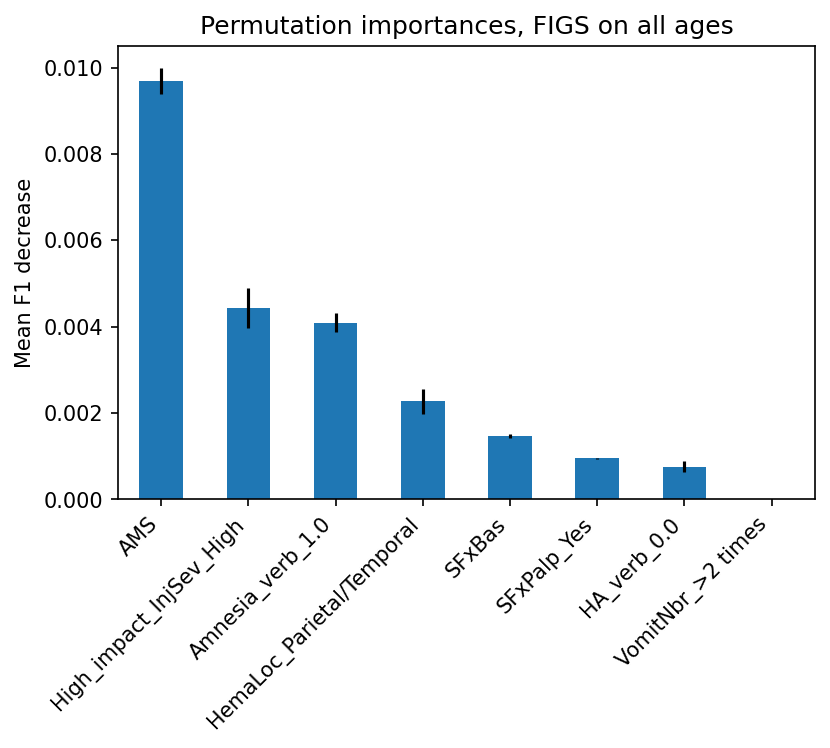

In [67]:
imp_plot('figs_all')
plt.title("Permutation importances, FIGS on all ages")

Text(0.5, 1.0, 'Permutation importances, TFIGS on <2')

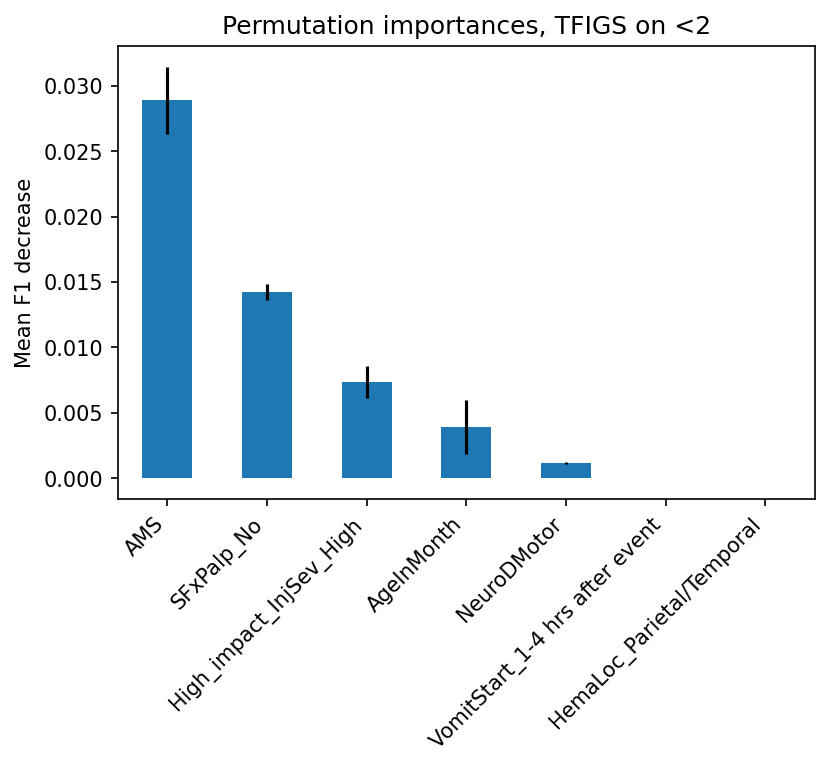

In [70]:
imp_plot('pfigs_young')
plt.title("Permutation importances, TFIGS on <2")

Text(0.5, 1.0, 'Permutation importances, TFIGS on >2')

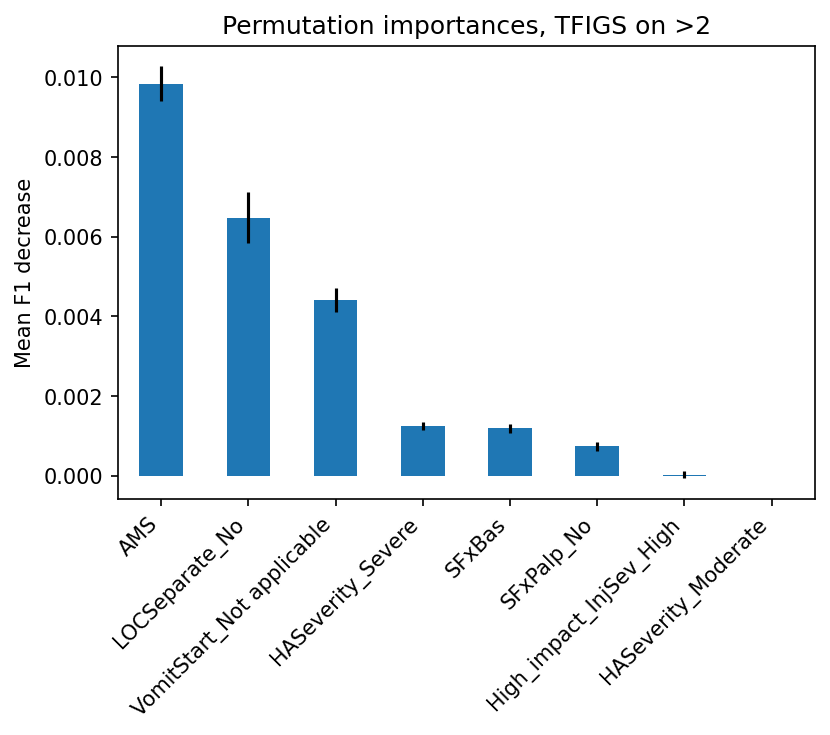

In [71]:
imp_plot('pfigs_old')
plt.title("Permutation importances, TFIGS on >2")